<a href="https://colab.research.google.com/github/SLCFLAB/DL-Forecasting/blob/main/Day_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install pmdarima

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
import itertools
import scipy.stats
import seaborn as sns
import warnings
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots  import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings(action='ignore')

# Data

### Data Load

In [7]:
gold_url = 'https://raw.githubusercontent.com/SLCFLAB/DL-Forecasting/main/DL/day1/data/gold.csv'
silver_url = 'https://raw.githubusercontent.com/SLCFLAB/DL-Forecasting/main/DL/day1/data/silver.csv'
platinum_url = 'https://raw.githubusercontent.com/SLCFLAB/DL-Forecasting/main/DL/day1/data/platinum.csv'
gold = pd.read_csv(gold_url, index_col=0)
silver = pd.read_csv(silver_url, index_col=0)
platinum = pd.read_csv(platinum_url, index_col=0)

In [8]:
price = gold.set_index(keys = 'Date')
diff = price.diff().dropna()

### Data describe

In [9]:
gold

,Date,Price
0,2017-01-03,1162.0
1,2017-01-04,1165.3
2,2017-01-05,1181.3
3,2017-01-06,1173.4
4,2017-01-09,1184.9
...,...,...
1285,2021-12-27,1808.8
1286,2021-12-28,1810.9
1287,2021-12-29,1805.8
1288,2021-12-30,1814.1


In [10]:
price

,Price
Date,
2017-01-03,1162.0
2017-01-04,1165.3
2017-01-05,1181.3
2017-01-06,1173.4
2017-01-09,1184.9
...,...
2021-12-27,1808.8
2021-12-28,1810.9
2021-12-29,1805.8


In [11]:
gold.isna().sum()

Date     0
Price    0
dtype: int64

In [12]:
gold.describe()

,Price
count,1290.000000
mean,1501.741550
std,254.202298
min,1162.000000
25%,1278.525000
50%,1411.600000
75%,1774.575000
max,2069.400000


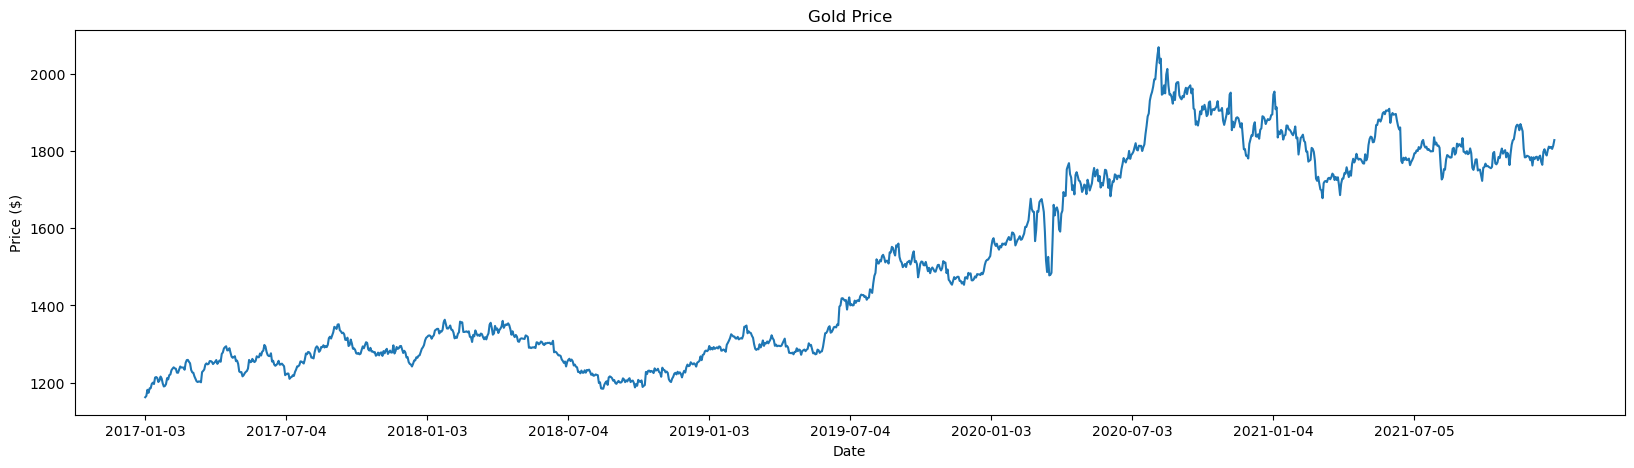

In [13]:
fig, ax = plt.subplots(figsize = (20,5))

ax.plot(price)
ax.set_title('Gold Price')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')

total_len = gold.shape[0]
ax.set_xticks(np.arange(0,total_len, 129))


plt.show()

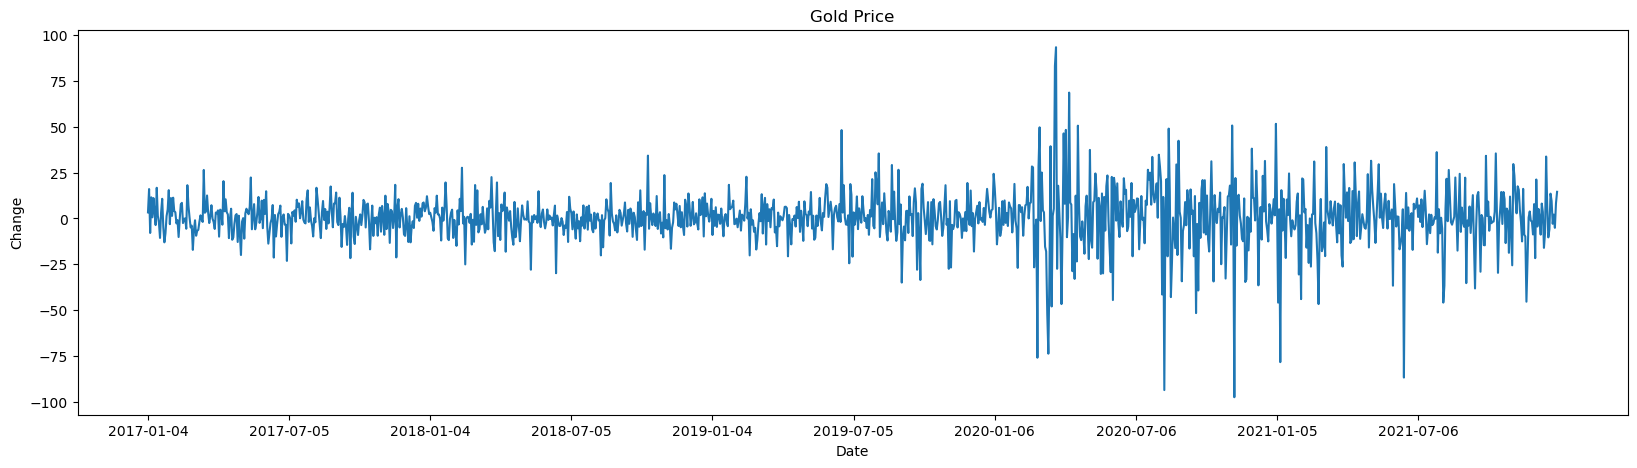

In [14]:
fig, ax = plt.subplots(figsize = (20,5))

ax.plot(diff)
ax.set_title('Gold Price')
ax.set_xlabel('Date')
ax.set_ylabel('Change')

total_len = gold.shape[0]
ax.set_xticks(np.arange(0,total_len, 129))


plt.show()

# Decomposition

### Box-Cox transformation

In [15]:
x = gold['Price'].to_numpy()
y, lambda_optimal = stats.boxcox(x)
print(lambda_optimal)

-1.6225791692441833


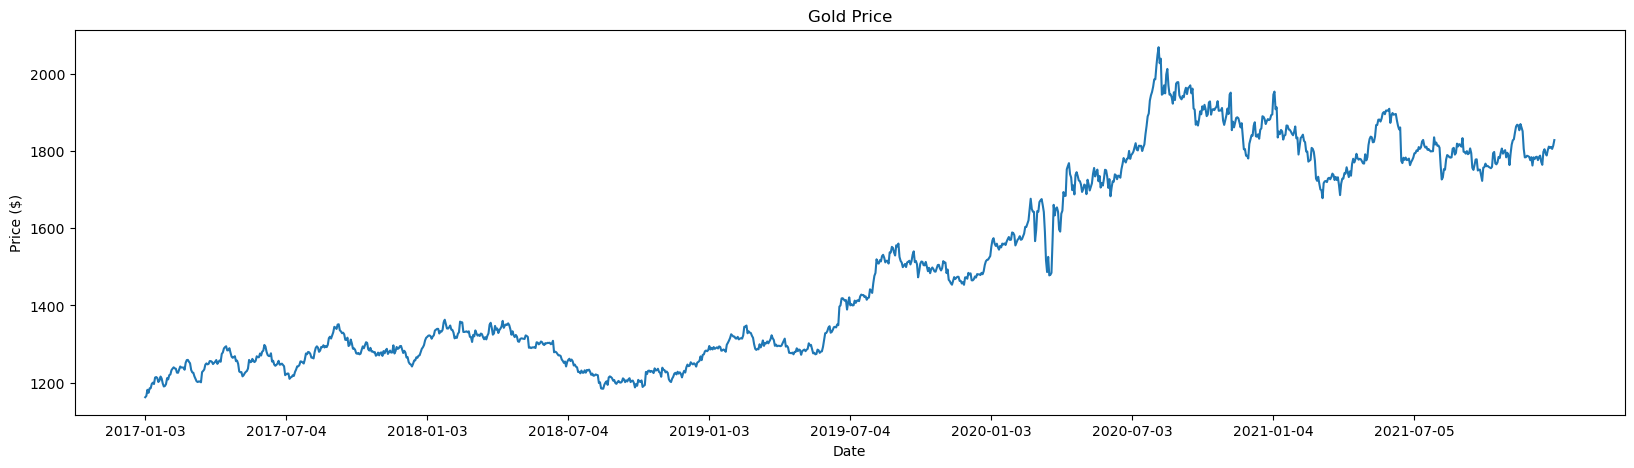

In [16]:
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(price)
ax.set_title('Gold Price')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
total_len = gold.shape[0]
ax.set_xticks(np.arange(0,total_len, 129))
plt.show()

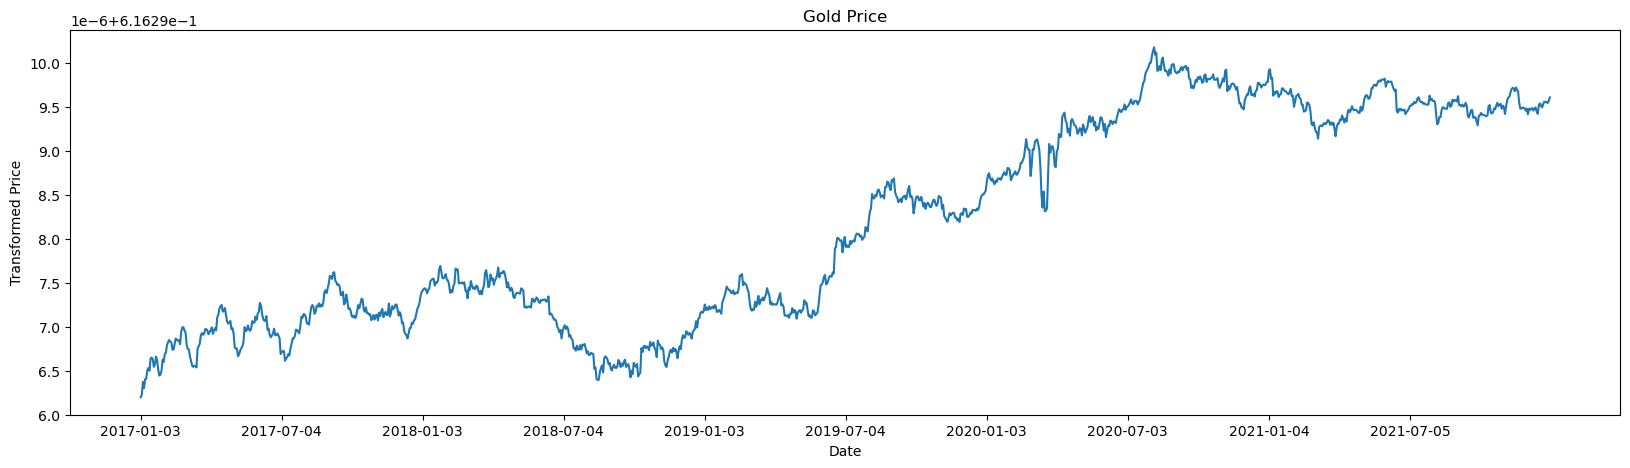

In [17]:
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(gold['Date'],y)
ax.set_title('Gold Price')
ax.set_xlabel('Date')
ax.set_ylabel('Transformed Price')
total_len = gold.shape[0]
ax.set_xticks(np.arange(0,total_len, 129))
plt.show()

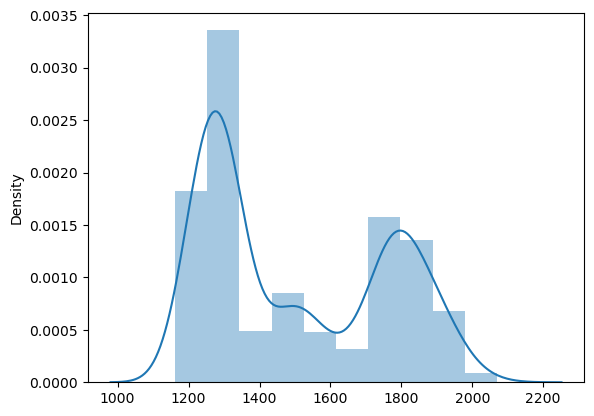

In [18]:
sns.distplot(x, hist=True)
plt.show()

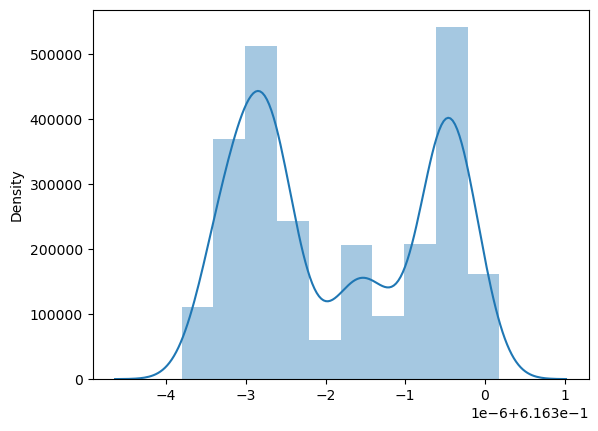

In [19]:
sns.distplot(y, hist=True)
plt.show()

### Moving average

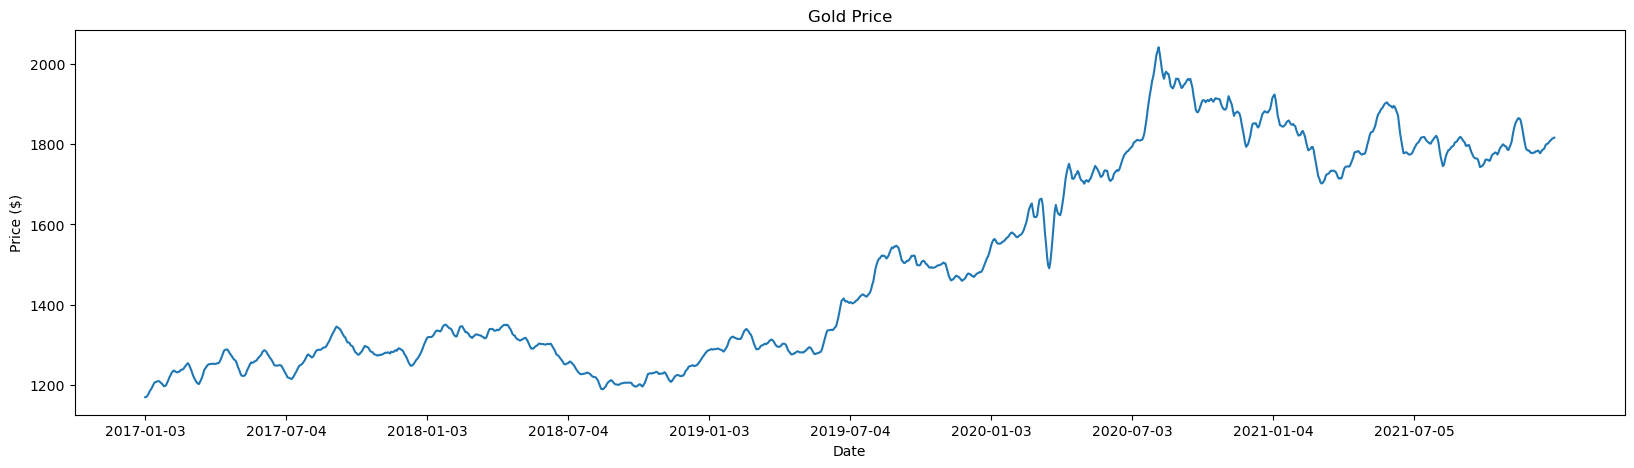

In [20]:
mas = []

for i in range(gold.shape[0]):
    if i >1:
        ma = np.array(gold['Price'][i-2:i+3]).mean()
        mas.append(ma)
    else:
        ma = np.array(gold['Price'][0:i+3]).mean()
        mas.append(ma)

fig, ax = plt.subplots(figsize = (20,5))

ax.plot(gold['Date'], mas)
ax.set_title('Gold Price')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')

total_len = gold.shape[0]
ax.set_xticks(np.arange(0,total_len, 129))


plt.show()

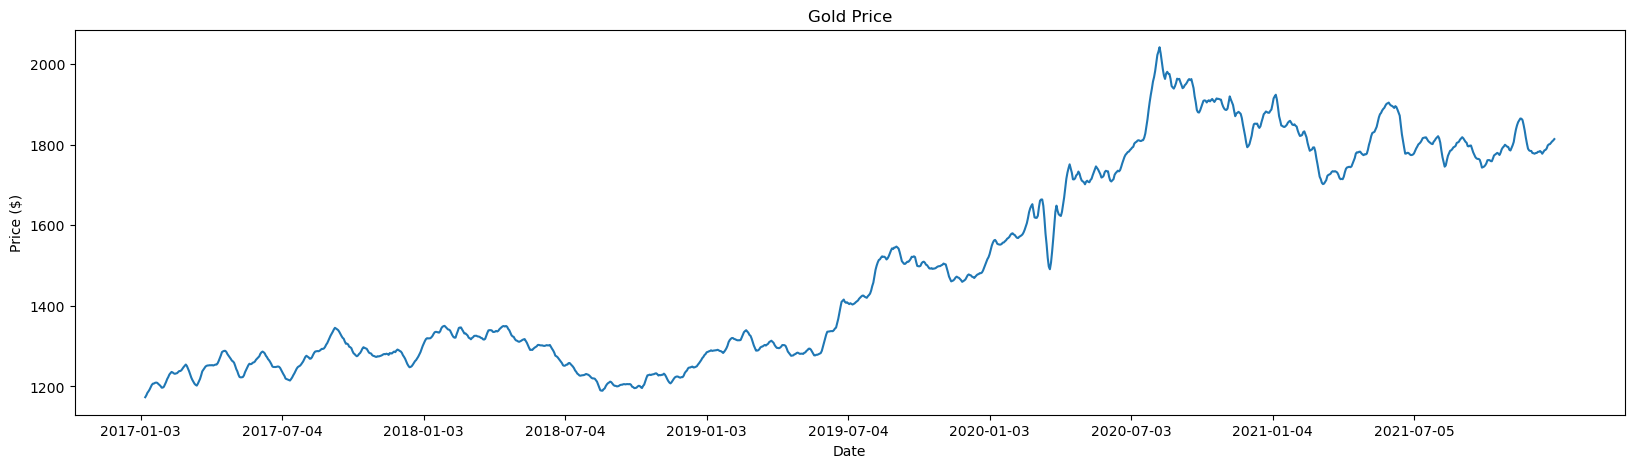

In [21]:
mas = gold['Price'].rolling(5).mean()

fig, ax = plt.subplots(figsize = (20,5))

ax.plot(gold['Date'], mas)
ax.set_title('Gold Price')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')

total_len = gold.shape[0]
ax.set_xticks(np.arange(0,total_len, 129))


plt.show()

## Classical Decomposition

### Trend -> Moving average
### Seasonal -> 각 period의 data - trend 평균

<Figure size 3000x1000 with 0 Axes>

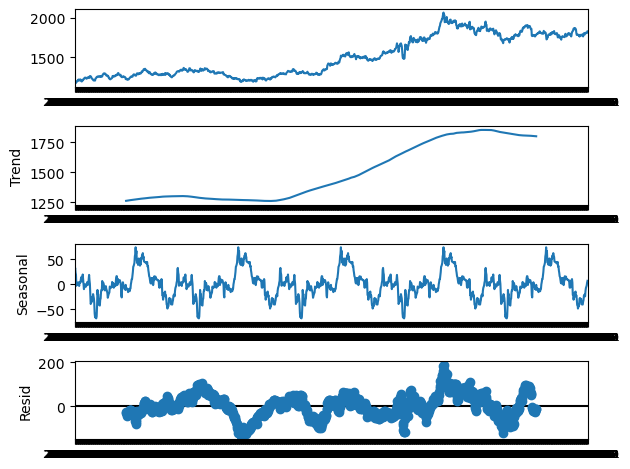

In [22]:
plt.figure(figsize=(30,10))
plt.rc('xtick', labelsize= 8)
gold_decomp = seasonal_decompose(price, model = 'additive',  period = 258)
gold_decomp.plot()
plt.show()

<Figure size 3000x1000 with 0 Axes>

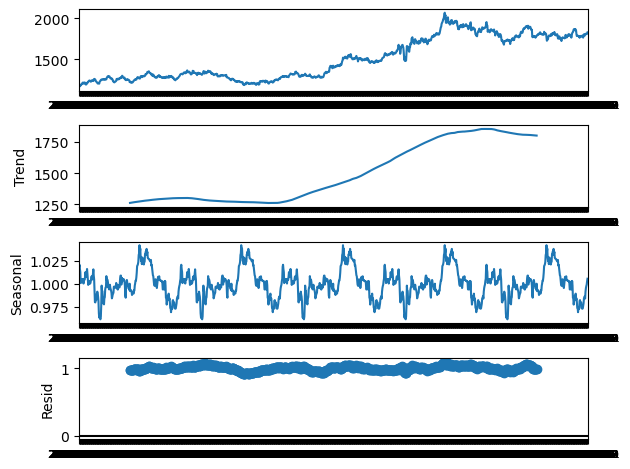

In [23]:
plt.figure(figsize=(30,10))
plt.rc('xtick', labelsize= 8)
gold_decomp = seasonal_decompose(price, model = 'multiplicative',  period = 258)
gold_decomp.plot()
plt.show()

# Stationarity

## Unit root test

In [24]:
def ADF(data):

    result = adfuller(data, autolag = 'AIC')

    print('-----ADF-----')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %1.10f' % result[1])
    print('Lag: %d' % result[2])
    print('observation: %d' % result[3])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key,value))

In [25]:
print(ADF(price))
print(ADF(diff))

-----ADF-----
ADF Statistic: -0.806442
p-value: 0.8172225725
Lag: 6
observation: 1283
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
None
-----ADF-----
ADF Statistic: -17.368823
p-value: 0.0000000000
Lag: 5
observation: 1283
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
None


## ACF / PACF

In [26]:
# reference: https://signature95.tistory.com/24,https://zephyrus1111.tistory.com/135

In [27]:
class autocorrelation:
    def __init__(self, data, lags):
        self.data =  data.reset_index(drop=True).squeeze()
        self.lags =lags

    def acf(self):
        acf_vals=[]

        for k in range(self.lags+1):
            mean = self.data.mean()
            sum_var = np.sum(np.square(self.data-mean))
            sum_ac = np.sum((self.data-mean)*(self.data.shift(k)-mean))
            acf_val = sum_ac/sum_var
            acf_vals.append(acf_val)
            #print(f"lag at {k}'s ac = ", acf_val)
        return acf_vals

    def pacf(self):
        pacf_vals=[]
        acfs = self.acf()

        for k in range(self.lags+1):
            if k == 0:
                pacf_val = 1
            else:
                gamma_array = np.array([acfs[k] for k in range(1,k+1)])
                gamma_matrix = []

                for i in range(k):
                    temp = [0]*k
                    temp[i:]=[acfs[j] for j in range(k-i)]
                    gamma_matrix.append(temp)

                gamma_matrix = np.array(gamma_matrix)
                gamma_matrix = gamma_matrix + gamma_matrix.T - np.diag(gamma_matrix.diagonal())
                pacf_val = np.linalg.inv(gamma_matrix).dot(gamma_array)[-1]
            pacf_vals.append(pacf_val)
            #print(f"lag at {k}'s pac = ", pacf_val)
        return pacf_vals

    def acf_plot(self):
        acfs = self.acf()
        scatter = pd.DataFrame()
        scatter['lags'] = [i for i in range(1,self.lags+1)]
        scatter['autocorrelation'] = acfs[1:]

        fig = plt.figure(figsize=(8,5))
        fig.set_facecolor('white')

        x = range(self.lags+1)
        markers, stemlines, baseline = plt.stem(x, acfs)#, use_line_collection= True)
        markers.set_color('blue')
        stemlines.set_linestyle('-')
        stemlines.set_color('blue')
        baseline.set_visible(True)

        n = self.data.shape[0]
        upper_limit=[]
        lower_limit=[]
        for k in x:
            if k==0 :
                upper_limit.append(0)
                lower_limit.append(0)
            else:
                term1 = np.sqrt((1+2*np.sum(np.square(acfs[1:k+1])))/n)
                upper_limit.append(1.96*term1)
                lower_limit.append(-1.96*term1)

        plt.fill_between(x, lower_limit, upper_limit, alpha=0.5)
        plt.scatter(x=scatter['lags'], y=scatter['autocorrelation'], edgecolors = 'red', linewidth=1,s=200, alpha=0.5)
        plt.show()

    def pacf_plot(self):
        pacfs = self.pacf()
        scatter = pd.DataFrame()
        scatter['lags'] = [i for i in range(1,self.lags+1)]
        scatter['autocorrelation'] = pacfs[1:]

        fig = plt.figure(figsize=(8,5))
        fig.set_facecolor('white')

        x = range(self.lags+1)
        markers, stemlines, baseline = plt.stem(x, pacfs)#, use_line_collection= True)
        markers.set_color('blue')
        stemlines.set_linestyle('-')
        stemlines.set_color('blue')
        baseline.set_visible(True)

        n = self.data.shape[0]
        upper_limit=[]
        lower_limit=[]
        for k in x:
            if k==0 :
                upper_limit.append(0)
                lower_limit.append(0)
            else:
                term1 = np.sqrt((1+2*np.sum(np.square(pacfs[1:k+1])))/n)
                upper_limit.append(1.96*term1)
                lower_limit.append(-1.96*term1)

        plt.fill_between(x, lower_limit, upper_limit, alpha=0.5)
        plt.scatter(x=scatter['lags'], y=scatter['autocorrelation'], edgecolors = 'red', linewidth=1,s=200, alpha=0.5)
        plt.show()

In [28]:
def acf_plot(data, lags):
    dat = data.reset_index(drop=True)
    df = dat.squeeze()
    #for i in range(lags+1):
    #    print(f"lag at {i}'s ac = ", round(df.autocorr(lag=i),2))
    scatter = pd.DataFrame()
    scatter['lags'] = [i for i in range(1,lags+1)]
    scatter['autocorrelation'] = [df.autocorr(lag=i) for i in range(1,lags+1)]
    fig = plot_acf(df, lags=lags)
    plt.scatter(x=scatter['lags'], y=scatter['autocorrelation'], edgecolors = 'red', linewidth=1,s=200, alpha=0.5)
    plt.show()

def pacf_plot(data, lags):
    #for i in range(lags+1):
    #    print(f"lag at {i}'s pac = ", round(pacf(data, alpha=.05)[0][i],2))
    scatter = pd.DataFrame()
    scatter['lags'] = [i for i in range(1,lags+1)]
    scatter['Partial autocorrelation'] = [pacf(data, alpha=.05)[0][i] for i in range(1,lags+1)]
    fig = plot_pacf(data, lags=lags)
    plt.scatter(x=scatter['lags'], y=scatter['Partial autocorrelation'], edgecolors = 'red', linewidth=1,s=200, alpha=0.5)
    plt.show()

In [29]:
price_ac = autocorrelation(price,20)

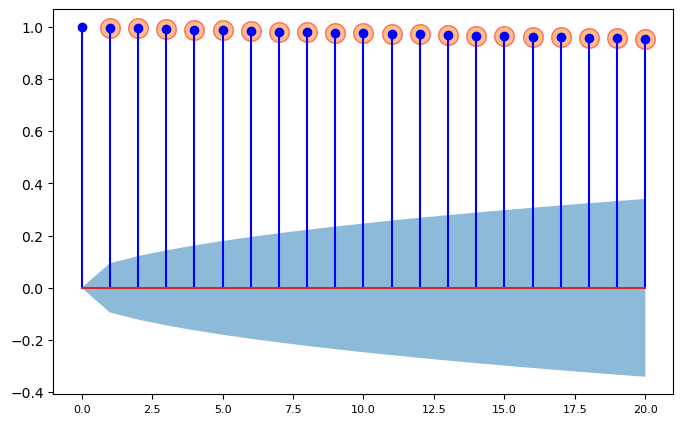

In [30]:
price_ac.acf_plot()

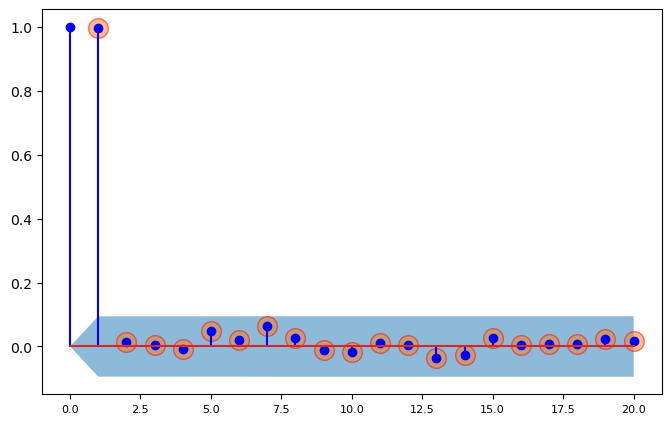

In [31]:
price_ac.pacf_plot()

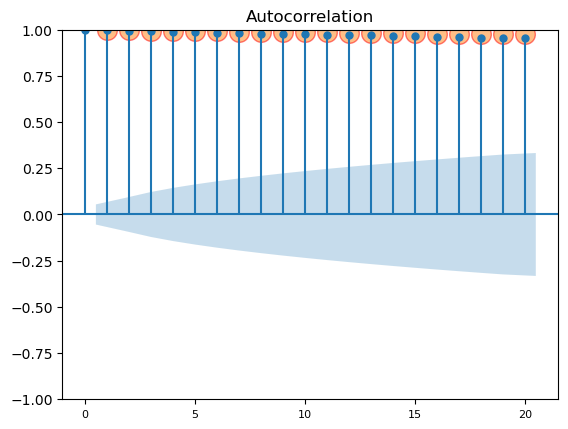

In [32]:
acf_plot(price, 20)

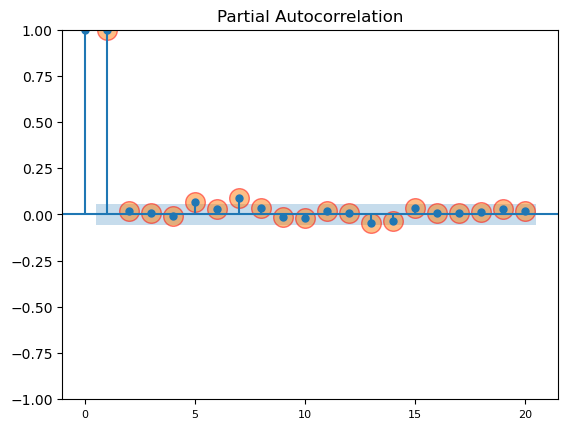

In [33]:
pacf_plot(price, 20)

In [34]:
diff_ac = autocorrelation(diff,20)

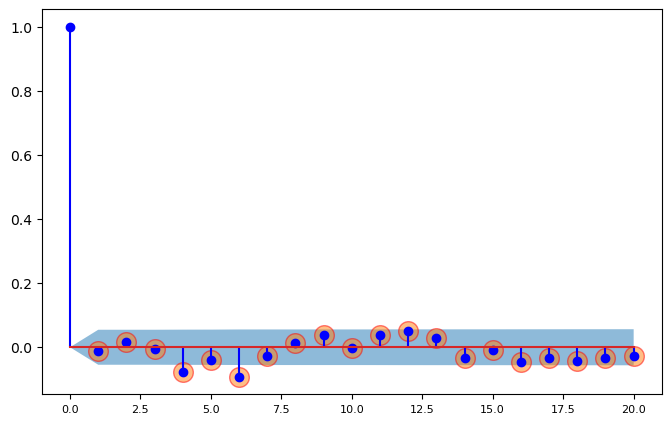

In [35]:
diff_ac.acf_plot()

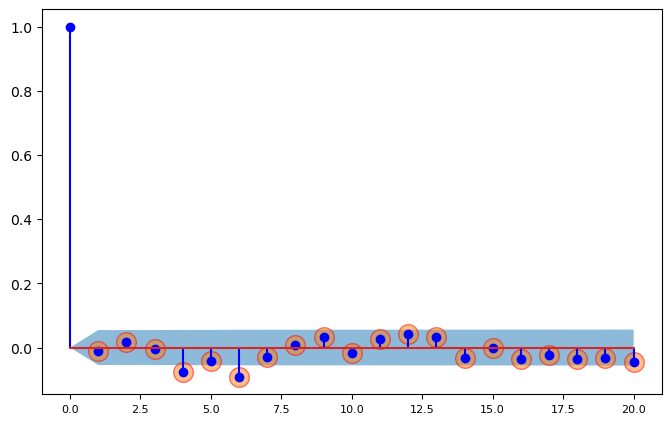

In [36]:
diff_ac.pacf_plot()

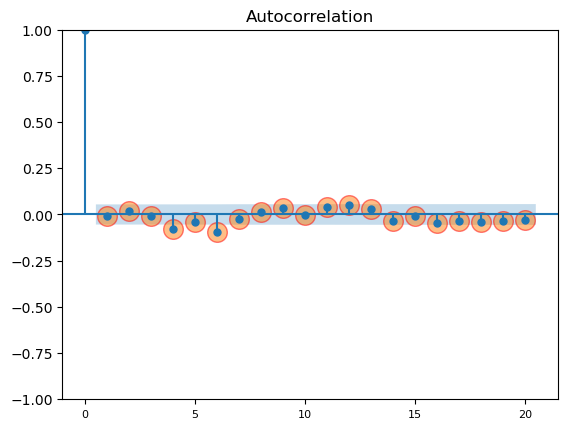

In [37]:
acf_plot(diff, 20)

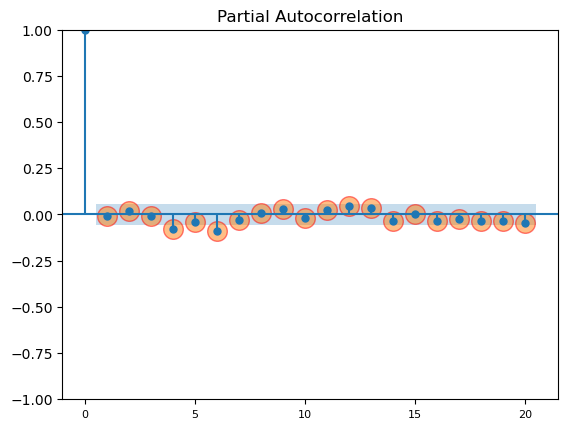

In [38]:
pacf_plot(diff, 20)

# ARIMA

## Train-Test split

In [39]:
forecasting_horizon = int(gold.shape[0]*0.2)
train = price[:-forecasting_horizon]
test = price[-forecasting_horizon:]

## Fitting

In [40]:
p = range(0,6)
d = range(0,3)
q = range(0,6)

orders = list(itertools.product(p,d,q))

In [41]:
#Gold select order
dict_model = {}

for order in orders:
    model = ARIMA(train, order = order)
    model_fit = model.fit()
    dict_model[order] = [model_fit.llf, model_fit.aic, model_fit.bic]

information = pd.DataFrame.from_dict(dict_model, orient='index', columns=['llf', 'Aic', 'Bic'])
print('By BIC')
print(information.sort_values(by=['Bic'], ascending =True))

By BIC
                   llf           Aic           Bic
(0, 1, 0) -4186.818237   8375.636475   8380.574759
(0, 2, 1) -4185.437423   8374.874846   8384.749475
(2, 1, 3) -4172.195781   8356.391562   8386.021269
(3, 1, 2) -4172.202305   8356.404609   8386.034316
(1, 1, 0) -4186.780252   8377.560504   8387.437073
...                ...           ...           ...
(0, 0, 4) -5974.532158  11961.064316  11990.699840
(0, 0, 2) -6195.197505  12398.395011  12418.152027
(0, 0, 1) -6398.740105  12803.480210  12818.297972
(0, 0, 5) -6393.161446  12800.322892  12834.897670
(0, 0, 0) -7071.464898  14146.929795  14156.808303

[108 rows x 3 columns]


In [42]:
model_aic = pm.auto_arima(train, information_criteria = 'aic')
model_bic = pm.auto_arima(train, information_criteria = 'bic')

print(model_aic.summary())
print(model_bic.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1032
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -4170.308
Date:                Fri, 26 Apr 2024   AIC                           8354.616
Time:                        21:13:52   BIC                           8389.184
Sample:                             0   HQIC                          8367.735
                               - 1032                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2006      0.107      1.876      0.061      -0.009       0.410
ar.L1          1.6116      0.033     48.502      0.000       1.546       1.677
ar.L2         -0.8931      0.034    -26.435      0.0

## Forecasting

In [43]:
#ARIMA(0,1,0)
arima_errors = []
arima_preds = []
order = (0,1,0)


for i in range(forecasting_horizon) :
    arima_model = ARIMA(price[:-forecasting_horizon+i], order = order)
    arima_model_fit = arima_model.fit()
    arima_pred = arima_model_fit.forecast(steps=1).item()
    arima_error = arima_pred - price.iloc[price.shape[0]-forecasting_horizon+i].item()
    arima_abs_error = abs(arima_error)
    arima_preds.append(arima_pred)
    arima_errors.append(arima_abs_error)


arima_abs_errors = np.array(arima_errors)
arima = arima_abs_errors.mean()
print(arima)

11.584883720930227


In [44]:
#Auto-ARIMA
arima_errors1 = []
arima_preds1 = []


for i in range(forecasting_horizon) :
    arima_model1 = pm.auto_arima(price[:-forecasting_horizon+i], max_p = 3, max_q=3, d =1, information_criteria = 'bic')
    arima_pred1 = arima_model1.predict(1).item()
    arima_error1 = arima_pred1 - price.iloc[price.shape[0]-forecasting_horizon+i].item()
    arima_abs_error1 = abs(arima_error1)
    arima_preds1.append(arima_pred1)
    arima_errors1.append(arima_abs_error1)


arima_abs_errors1 = np.array(arima_errors1)
arima1 = arima_abs_errors1.mean()
print(arima1)

11.551172589344901


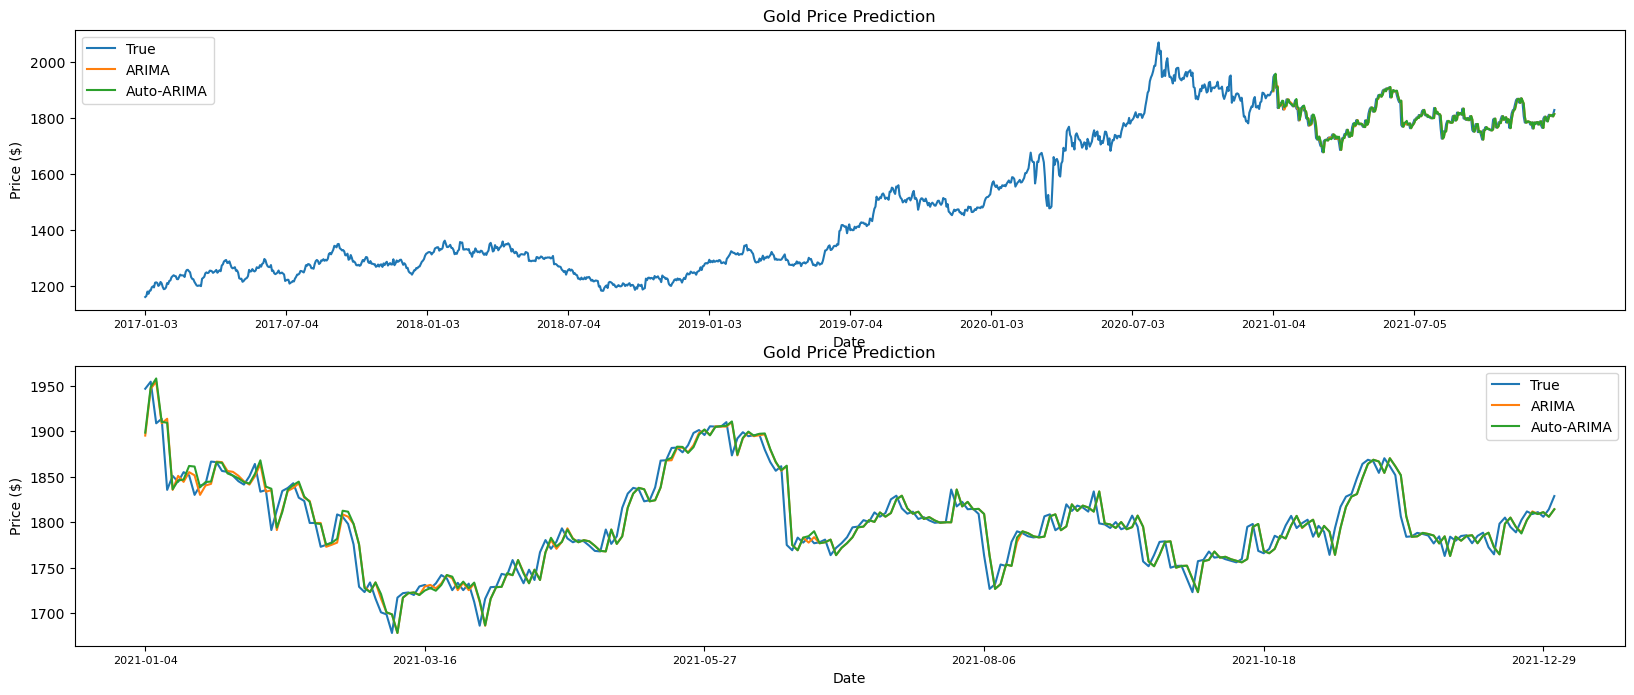

In [45]:
preds = pd.DataFrame(arima_preds, index = gold['Date'][-forecasting_horizon:])
preds1 = pd.DataFrame(arima_preds1, index = gold['Date'][-forecasting_horizon:])

fig, ax = plt.subplots(2,1,figsize = (20,8))
x1 = gold['Date']
x2 = gold['Date'][-forecasting_horizon:]

ax[0].plot(x1, price, label = 'True')
ax[0].plot(x2, preds, label = 'ARIMA')
ax[0].plot(x2, preds1, label = 'Auto-ARIMA')
ax[0].set_title('Gold Price Prediction')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Price ($)')
ax[0].legend()

ax[1].plot(x2, price[-forecasting_horizon:], label = 'True')
ax[1].plot(x2, preds, label = 'ARIMA')
ax[1].plot(x2, preds1, label = 'Auto-ARIMA')
ax[1].set_title('Gold Price Prediction')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Price ($)')
ax[1].legend()

total_len = gold.shape[0]
ax[0].set_xticks(np.arange(0,total_len, 129))
ax[1].set_xticks(np.arange(0,forecasting_horizon, int(forecasting_horizon*0.2)))


plt.show()

In [46]:
order = (0,1,0)
arima_model_dms = ARIMA(price[:-forecasting_horizon], order = order)
arima_model_dms_fit = arima_model_dms.fit()
arima_dms_pred = arima_model_dms_fit.forecast(steps=forecasting_horizon)
arima_dms_error = arima_dms_pred - gold['Price'][price.shape[0]-forecasting_horizon:]
arima_dms_abs_error = abs(arima_dms_error)
arima_dms_abs_error = np.array(arima_dms_abs_error)
print(arima_dms_abs_error.mean())

arima_model_dms1 = pm.auto_arima(price[:-forecasting_horizon], max_p = 3, max_q=3, d =1, information_criteria = 'bic')
arima_dms_pred1 = arima_model_dms1.predict(forecasting_horizon)
arima_dms_error1 = arima_dms_pred1 - gold['Price'][price.shape[0]-forecasting_horizon:]
arima_dms_abs_error1 = abs(arima_dms_error1)
arima_dms_abs_error1 = np.array(arima_dms_abs_error1)
arima_dms_abs_error1.mean()

97.13333333333325


191.32826600963224

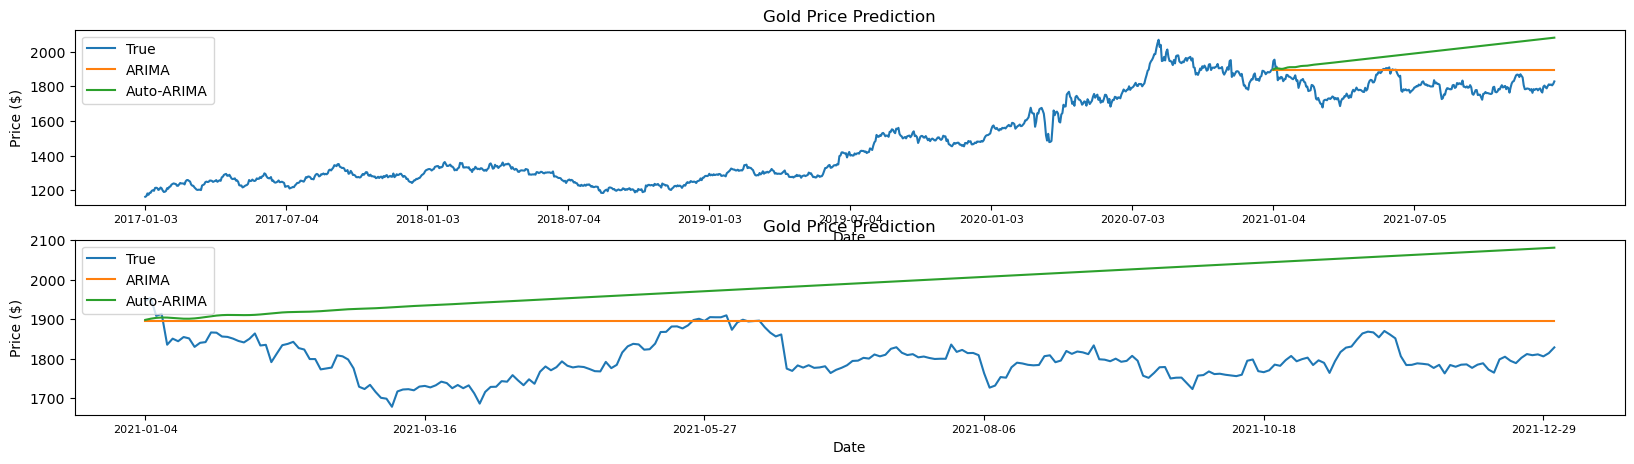

In [47]:
preds_dms= pd.DataFrame(arima_dms_pred.to_numpy(), index = gold['Date'][-forecasting_horizon:])
preds_dms1= pd.DataFrame(arima_dms_pred1.to_numpy(), index = gold['Date'][-forecasting_horizon:])


fig, ax = plt.subplots(2,1,figsize = (20,5))
x1 = gold['Date']
x2 = gold['Date'][-forecasting_horizon:]

ax[0].plot(x1, price, label = 'True')
ax[0].plot(x2, preds_dms, label = 'ARIMA')
ax[0].plot(x2, preds_dms1, label = 'Auto-ARIMA')
ax[0].set_title('Gold Price Prediction')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Price ($)')
ax[0].legend()

ax[1].plot(x2, price[-forecasting_horizon:], label = 'True')
ax[1].plot(x2, preds_dms, label = 'ARIMA')
ax[1].plot(x2, preds_dms1, label = 'Auto-ARIMA')
ax[1].set_title('Gold Price Prediction')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Price ($)')
ax[1].legend()

total_len = gold.shape[0]
ax[0].set_xticks(np.arange(0,total_len, 129))
ax[1].set_xticks(np.arange(0,forecasting_horizon, int(forecasting_horizon*0.2)))


plt.show()